# Лабораторна робота №2

### Студента групи МІТ-31 (підгрупа 1)

### Добровольського Арсенія Михайловича

### Завдання
**Частина 1: Регресія на згенерованому наборі даних**

1. Згенеруйте набір даних для регресії за допомогою sklearn.datasets.make_regression (використати не менше 5 параметрів). Набір даних повинен містити не менше 1000 екземплярів.

2. Розділіть дані на навчальний та тестовий набори у співвідношенні 80% - 20%.

3. Побудуйте модель регресії на навчальних даних та оцініть її точність на тестових даних. Використовуйте будь-який регресійний алгоритм за вибором (наприклад, лінійна регресія, дерево рішень, Random Forest тощо).


MSE = 110.09, R^2 = 0.98


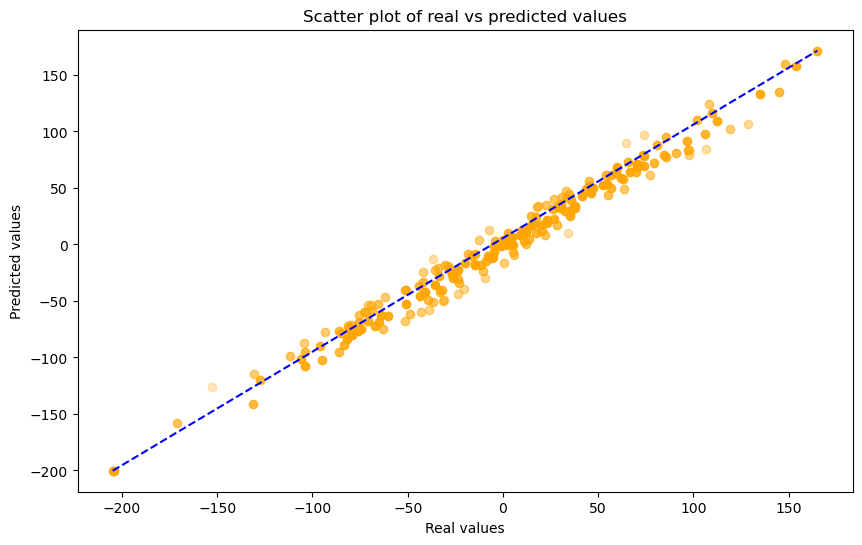

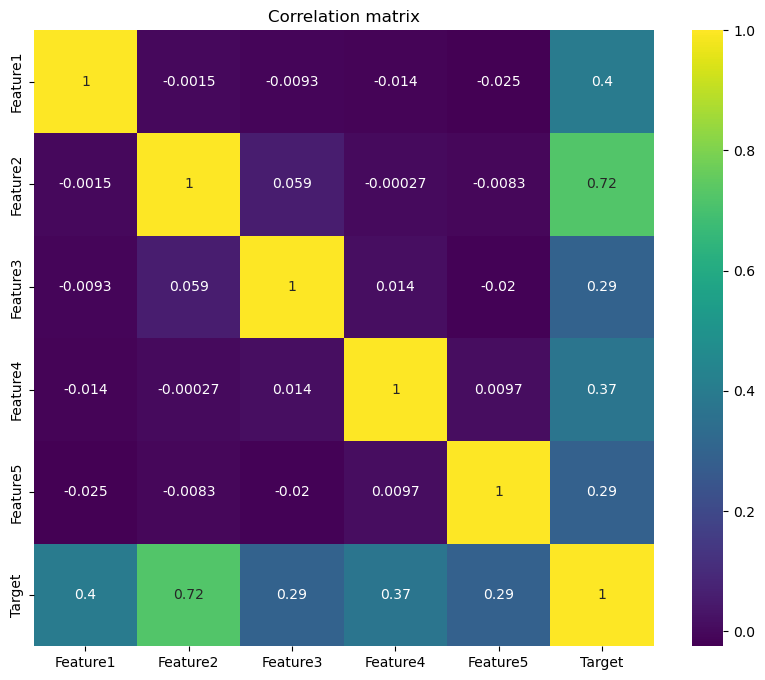

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=5, noise=10, random_state=42)

df = pd.DataFrame(data=X, columns=[f'Feature{i+1}' for i in range(5)])
df['Target'] = y
df.to_csv('dataset1.csv', index = False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"\nMSE = {mse:.2f}, R^2 = {r2:.2f}")

distances = np.abs(y_test - y_pred) # Distance between real and predicted values
max_distance = np.max(distances) # For setting transparency

# Making a plot
plt.figure(figsize=(10, 6))
for i in range(len(y_test)):
    alpha = 1 - (distances[i] / max_distance)  # Transparency which depends on the distance
    plt.scatter(y_test[i], y_pred[i], c='orange', alpha=alpha)

plt.plot([min(y_test), max(y_test)], [min(y_pred), max(y_pred)], linestyle='--', color = 'blue')
plt.title("Scatter plot of real vs predicted values")
plt.xlabel("Real values")
plt.ylabel("Predicted values")
plt.show()

# Correlation matrix generation
data = pd.read_csv('dataset1.csv')
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.title('Correlation matrix')
plt.show()

**Частина 2: Аналіз часових даних**

1. Знайдіть набір часових даних в Інтернеті. Це може бути, наприклад, набір даних про ціни на акції, погоду, рух транспорту, або будь-які інші дані, які залежать від часу.

2. Завантажте та візуалізуйте ці дані. Переконайтеся, що ви розумієте основні характеристики часового ряду, такі як тренд, сезонність, аномалії тощо.

3. Використовуйте методи аналізу часових рядів, такі як розкладання на компоненти, автокореляція тощо, для отримання інсайтів і підготовки даних для моделювання.

            Passengers
Date                  
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


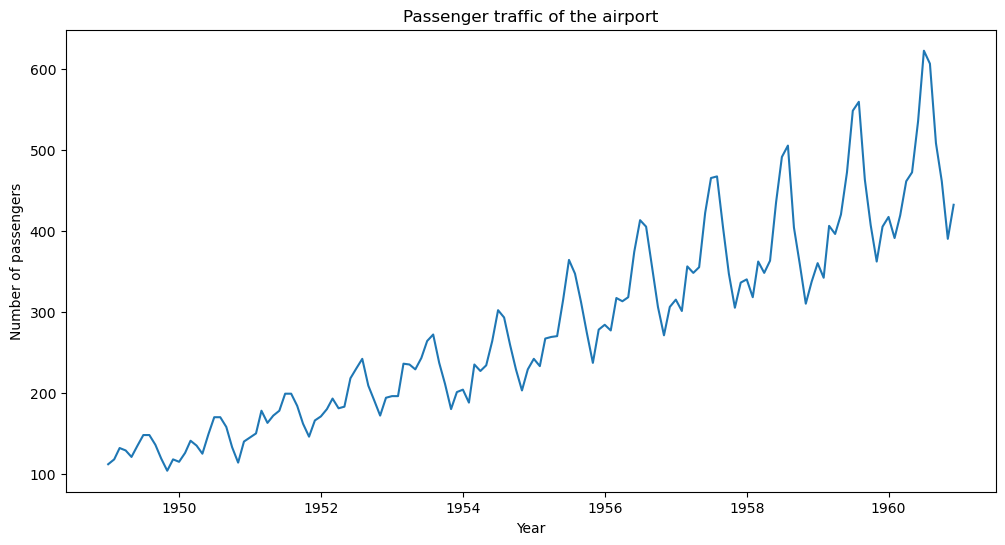

---------- Augmented Dickey-Fuller test: ----------
ADF Statistic: 0.82
p-value: 0.99
Critical values:
1%: -3.48
5%: -2.88
10%: -2.58


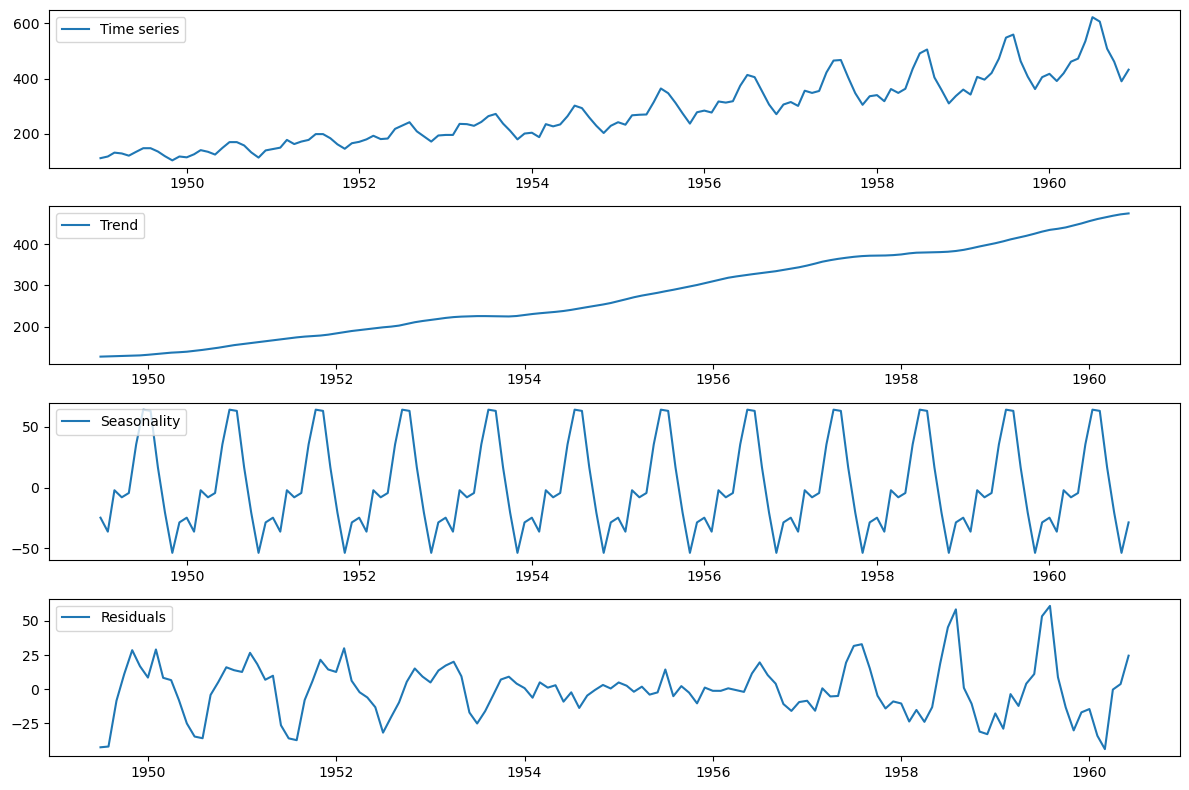

23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
504 1961-11-27  498.608511  469.317360  526.959361
505 1961-11-28  497.074770  467.319108  526.423047
506 1961-11-29  494.898299  464.003510  522.566609
507 1961-11-30  492.123197  463.409874  522.106282
508 1961-12-01  488.809057  459.695467  518.139231


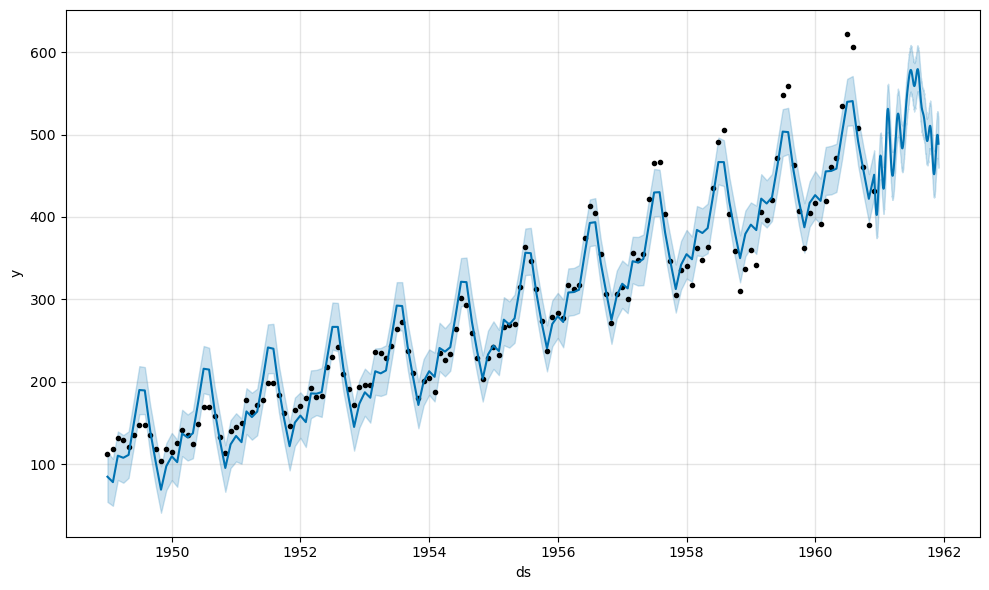

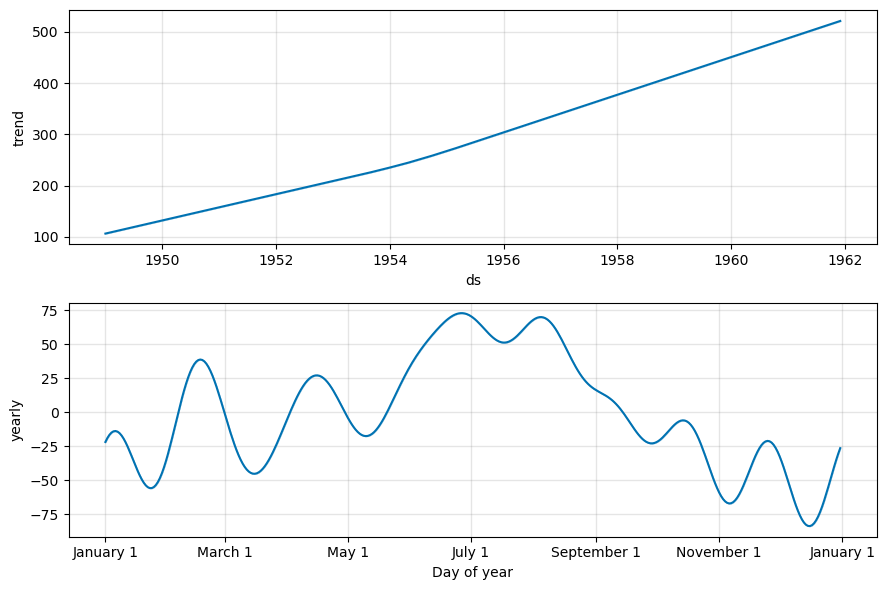

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter('ignore')

data = pd.read_csv('air_passengers.csv', parse_dates=['Date'], index_col='Date')
print(data.head())

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Passengers'])
plt.title('Passenger traffic of the airport')
plt.xlabel('Year')
plt.ylabel('Number of passengers')
plt.show()

# Checking the stationarity of the time series
result = adfuller(data)
print("---------- Augmented Dickey-Fuller test: ----------")
print(f'ADF Statistic: {result[0]:.2f}')
print(f'p-value: {result[1]:.2f}')
print('Critical values:')
for key, value in result[4].items():
    print(f'{key}: {value:.2f}')

# Decomposition
decomposition = seasonal_decompose(data, model='additive', period=12)
trend_component = decomposition.trend
seasonality_component = decomposition.seasonal
residuals = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Time series')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_component, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality_component, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Creating the model and training it
data.reset_index(inplace=True)
data.columns = ['ds', 'y'] # Renaming columns for Prophet model
model = Prophet()
model.fit(data)

# Making predictions
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Making a plot with real values and predicted ones
plot = model.plot(forecast)
components = model.plot_components(forecast)